# Cluster level integration (matching up clusters with correlation)

In [4]:
from __init__ import *
import seaborn as sns 
from scipy.stats import zscore
import matplotlib.pyplot as plt
from natsort import natsorted

import snmcseq_utils
import CEMBA_update_mysql

In [13]:
# snmc-tsne-clustering-data
# snatac-tsne-clustering-data
# snrna-tsne-clustering-data

In [4]:
# get cluster wise feature for each modality

In [5]:
# select features in common

In [6]:
# do all-to-all correlations

In [7]:
# select subset of cell types and look at correlations

# references (gene_annotation)

In [72]:
df_genes = pd.read_table(
    os.path.join(PATH_REFERENCES, 'Annotation', 'gencode.vM16.annotation_genes.tsv'), index_col='gene_id')
df_genes.head()

,gene_name,chr,start,end,strand,gene_type
gene_id,,,,,,
ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC
ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA
ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding
ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene
ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC


# ATAC preprocessing

In [5]:
# atac tsne, clustering, and cells
with snmcseq_utils.cd('/cndd/Public_Datasets/CEMBA/snATACSeq/MiniBrain_fromRongxin'):
    df_clst_atac = pd.read_table('XW45_cluster.txt', header=None, names=['sample', 'cluster_ID'], index_col='sample')
    df_tsne_atac = pd.read_table('XW45_tsne.txt', header=None, names=['sample', 'tsne_x', 'tsne_y'], index_col='sample')
df_info_atac = pd.merge(df_clst_atac, df_tsne_atac, left_index=True, right_index=True)
cells_atac = df_info_atac.index.values
print(cells_atac.shape)

(8567,)


In [9]:
# atac data
ens = 'Ens10'
f = '/cndd/fangming/atac_count_help/test_counts_dmr.tsv'
f = '/cndd/fangming/atac_count_help/counts_dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed_20dms.tsv'
df_atac_raw = pd.read_table(f)

df_atac_raw = df_atac_raw.set_index('gene')
df_atac_raw.head()

,AGCGATAGAACCAGGTAAGAGATGTATAGCCT,AGCGATAGAACCAGGTATTCGTTGTAATCTTA,AGCGATAGAACCAGGTATTCGTTGTATAGCCT,AGCGATAGAACCAGGTGAAGTATGTATAGCCT,AGCGATAGAACCAGGTGGATACTACAGGACGT,AGCGATAGAACCAGGTTAAGATCCGGCTCTGA,AGCGATAGAAGAGGCAAAGGAGTAAGGCGAAG,AGCGATAGAAGAGGCAAAGGCTATATAGAGGC,AGCGATAGAAGAGGCAAAGGCTATCCTATCCT,AGCGATAGAAGAGGCAACTGCATAAGGCGAAG,...,TCTCGCGCTTCCATCCAAGAGATGAGGCGAAG,TCTCGCGCTTCCATCCAAGAGATGGGCTCTGA,TCTCGCGCTTCCATCCATAGCCTTCCTATCCT,TCTCGCGCTTCCATCCATAGCCTTGGCTCTGA,TCTCGCGCTTCCATCCGGATACTAATAGAGGC,TCTCGCGCTTCCATCCGGTTAGACCCTATCCT,TCTCGCGCTTCCATCCGGTTAGACGGCTCTGA,TCTCGCGCTTCCATCCTCCGGTAACAGGACGT,TCTCGCGCTTCCATCCTGCCTTACCCTATCCT,TCTCGCGCTTCCATCCTTGGAAGTCCTATCCT
gene,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# atac bed
ens = 'Ens10'
f = '/cndd/fangming/atac_count_help/dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed_3dms.chr2.tsv.DMR.bed'
f = os.path.join(PATH_ENSEMBLES, ens, 'dmr', 'dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed_20dms.tsv.DMR.bed')
df_mcc_bed = pd.read_table(f, header=None, 
                       index_col='name',
                       dtype={'chr': object},
                       names=['chr', 'start', 'end', 'name', 'ndms'])
df_mcc_bed['length'] = df_mcc_bed['end'] - df_mcc_bed['start']
df_mcc_bed.head()

,chr,start,end,ndms,length
name,,,,,
0,1,3532561,3533460,38,899
1,1,4766666,4767296,26,630
2,1,4833409,4834142,21,733
3,1,4923127,4924054,20,927
4,1,5020575,5021920,42,1345


In [11]:
tmp = df_atac_raw.divide(df_mcc_bed['length'], axis=0)
logtpm = np.log10(1 + tmp.divide(tmp.sum(axis=0), axis=1))

In [12]:
# find cells in common
cells_atac = np.intersect1d(logtpm.columns, df_info_atac.index)
logtpm = logtpm[cells_atac]
df_info_atac = df_info_atac.loc[cells_atac, :]
print(cells_atac.shape)

(7972,)


In [13]:
# get gene*cluster matrix 
df_atac = logtpm
clusters_atac = pd.DataFrame() 
for label, df_sub in df_info_atac.groupby('cluster_ID'):
    samples = df_sub.index.values
    clusters_atac[label] = df_atac[samples].mean(axis=1)

logging.info("Output shape: {}".format(clusters_atac.shape))
# reorder by natural sort
clusters_atac = clusters_atac[natsorted(clusters_atac.columns)]
clusters_atac.columns = ['atac_'+col.strip('C') for col in clusters_atac.columns]
clusters_atac.head()

,atac_1,atac_2,atac_3,atac_4,atac_5,atac_6,atac_7,atac_8,atac_9,atac_10,atac_11,atac_12,atac_13,atac_14,atac_15,atac_16,atac_17,atac_18,atac_19
gene,,,,,,,,,,,,,,,,,,,
0,0.0,0.000003,0.000000,0.000000,0.000006,0.000002,0.000002,9.706738e-07,0.000023,9.279317e-07,0.000000,0.000005,4.074918e-07,0.000000,1.499228e-05,0.000000,0.000011,0.000003,1.539128e-05
1,0.0,0.000000,0.000000,0.000015,0.000000,0.000004,0.000007,2.447543e-05,0.000010,4.985418e-07,0.000000,0.000006,5.477024e-06,0.000012,0.000000e+00,0.000014,0.000004,0.000000,6.322125e-07
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000012,0.000003,3.708814e-06,0.000000,0.000000e+00,0.000012,0.000001,0.000000e+00,0.000000,1.446662e-06,0.000000,0.000002,0.000014,6.006471e-07
3,0.0,0.000000,0.000000,0.000000,0.000006,0.000003,0.000020,5.499259e-06,0.000005,0.000000e+00,0.000001,0.000015,0.000000e+00,0.000000,9.174872e-07,0.000000,0.000008,0.000005,4.981168e-06
4,0.0,0.000009,0.000007,0.000000,0.000007,0.000009,0.000013,5.211788e-06,0.000011,3.624088e-06,0.000004,0.000006,2.413317e-06,0.000008,2.547243e-06,0.000164,0.000008,0.000011,9.544939e-06


# MC preprocessing

In [14]:
# get dmr data
ens = 'Ens10'

# all dmr info
f = os.path.join(PATH_ENSEMBLES, ens, 'dmr', 
                 'dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed.tsv')
df_mcc_raw = pd.read_table(f, 
                       dtype={'#chr': object}).rename(columns={'#chr': 'chr'})
# dmr bed file
f = os.path.join(PATH_ENSEMBLES, ens, 'dmr', 
                 'dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed_20dms.tsv.DMR.bed')
# f = ('/cndd/fangming/atac_count_help/dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed_3dms.chr2.tsv.DMR.bed')
df_mcc_bed = pd.read_table(f, header=None, 
                       dtype={'chr': object},
                       names=['chr', 'start', 'end', 'name', 'ndms'])

# get dmr info only from dmr bed file
# df_mcc = df_mcc_raw.set_index(['chr', 'start', 'end']).loc[df_mcc_bed.set_index(['chr', 'start', 'end']).index, :]
clusters_mcc = pd.merge(df_mcc_raw, df_mcc_bed, on=['chr', 'start', 'end']).set_index('name')
clusters_mcc = clusters_mcc.filter(regex="^methylation_level_*")
print(clusters_mcc.shape)
clusters_mcc.head()

(60966, 26)


,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_10_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_11_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_12_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_13_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_14_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_15_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_16_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_17_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_18_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_19_Ens10,...,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_25_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_26_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_2_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_3_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_4_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_5_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_6_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_7_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_8_Ens10,methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_9_Ens10
name,,,,,,,,,,,,,,,,,,,,,
0,0.908898,0.358108,0.556485,0.638191,0.747596,0.952607,0.959538,0.887043,0.948198,0.801047,...,0.659091,0.760870,0.875000,0.769416,0.645108,0.570025,0.639818,0.668588,0.654472,0.862782
1,0.515152,0.912844,0.561644,0.562963,0.470588,0.839779,0.207071,0.481928,0.525896,0.491018,...,0.957447,0.280702,0.489831,0.402337,0.351310,0.525054,0.097493,0.579747,0.809668,0.908517
2,0.946058,0.940092,0.983607,0.983871,0.993007,0.973856,0.994382,0.984962,0.889447,0.740000,...,0.967213,0.800000,0.459883,0.366723,0.903226,0.966777,0.695513,0.834586,0.884758,0.955224
3,0.507553,0.918841,0.579462,0.503788,0.440000,0.886567,0.829457,0.887574,0.901515,0.764543,...,0.925000,0.314286,0.657551,0.497062,0.430456,0.445763,0.557912,0.477642,0.554955,0.939759
4,0.137709,0.508065,0.070840,0.141580,0.119670,0.525620,0.394515,0.195980,0.424000,0.135246,...,0.553571,0.212766,0.041602,0.055850,0.096023,0.064275,0.094760,0.086266,0.070408,0.551020


In [15]:
# get mc clusters and name clusters properly

database = DATABASE
engine = CEMBA_update_mysql.connect_sql(database) 
tsne_type = 'mCHmCG_ndim2_perp30'
cluster_type = 'mCHmCG_lv_npc50_k30'
sql = """SELECT cell_name, tsne_x_{}, tsne_y_{}, cluster_{}, annotation_{}
        FROM {} 
        JOIN cells ON cells.cell_id = {}.cell_id""".format(tsne_type, tsne_type, cluster_type, cluster_type, 
                                                       ens, ens)

df_info_mc = pd.read_sql(sql, engine, index_col='cell_name')
print(df_info_mc.shape)
df_info_mc.head()

df_clst_annot_mc = df_info_mc[
    ['cluster_'+cluster_type, 'annotation_'+cluster_type]].groupby('cluster_'+cluster_type).first().fillna('Glia/Unlabeled')
print(df_clst_annot_mc.shape)

# rename mcc
clusters_mcc.columns = ['mc_' + col[len('methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_'):-len('_{}'.format(ens))] 
 + '_' + df_clst_annot_mc.loc[
     int(col[len('methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_'):-len('_{}'.format(ens))]), 
            'annotation_'+cluster_type] for col in clusters_mcc.columns]

(5352, 4)
(26, 1)


In [43]:
# remove/impute nan values
clusters_mcc = clusters_mcc[clusters_mcc.isnull().sum(axis=1)==0] 

(60960, 26)

# ATAC preproc 2 (genebody tpm)

In [70]:
f = '/cndd/Public_Datasets/CEMBA/snATACSeq/Datasets/CEMBA_3C_171206/CEMBA_3C_171206_merged.gene10kb.counts.tsv'
df = pd.read_table(f, index_col='gene')

In [73]:
# counts to logtpm
gene_lengths = df_genes.loc[df.index, 'end'] - df_genes.loc[df.index, 'start']
gene_lengths_flanking = gene_lengths + 1e4 

tmp = df.divide(gene_lengths_flanking, axis=0)
tmp = tmp.divide(tmp.sum(axis=0))*1e6
logtpm = np.log10(1 + tmp)

In [ ]:
# cluster info
# cluster level
# check nan

# correlate

In [64]:

top_genes_atac = clusters_atac.std(axis=1).sort_values(ascending=False)# .head(50000)
top_genes_mcc = clusters_mcc.std(axis=1).sort_values(ascending=False)# .head(50000)
index_both_top = top_genes_atac.index.intersection(top_genes_mcc.index)
print(len(index_both_top))


data_atac = clusters_atac.rank(pct=True)
data_mcc = clusters_mcc.rank(pct=True)

feature_genes = index_both_top.tolist() 
feature_genes = np.unique(feature_genes)
print(len(feature_genes))

data_atac = data_atac.loc[feature_genes, :]
data_mcc = data_mcc.loc[feature_genes, :]

nclst_atac = data_atac.shape[1]
nclst_mcc = data_mcc.shape[1]
print(data_atac.shape)
print(data_mcc.shape)



60960
60960
(60960, 19)
(60960, 26)


In [65]:
corr = np.corrcoef(np.concatenate((data_atac.values, data_mcc.values), axis=1).T)
print(corr.shape)

(45, 45)


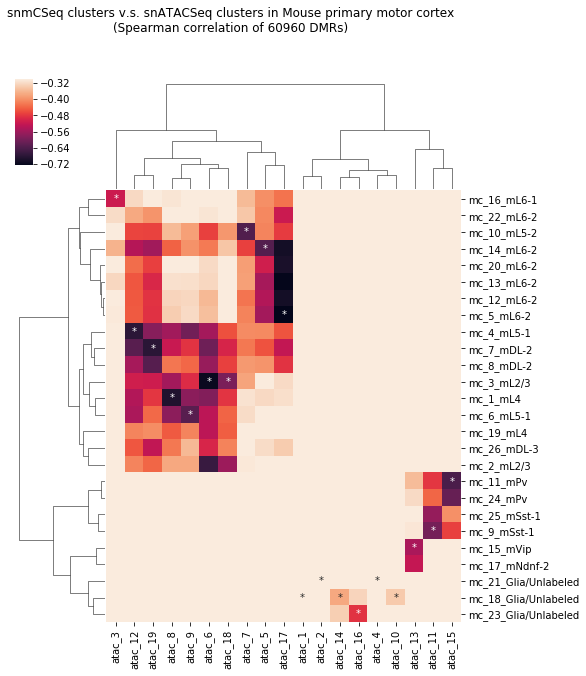

In [69]:
df_corr = pd.DataFrame(corr[nclst_atac:, :nclst_atac], index=data_mcc.columns, columns=data_atac.columns)
# df_corr = df_corr.T
reject_threshold = 100 

df_corr
df_annot = pd.DataFrame(columns=df_corr.columns, index=df_corr.index)
for col, idx in df_corr.idxmin().iteritems():
    if df_corr.loc[idx, col] < reject_threshold:
        # print(col + ' --> ' + idx)
        df_annot.loc[idx, col] = '*'
    else:
        # print(col + ' cell type not matched!')
        pass
df_annot = df_annot.fillna('')

g = sns.clustermap(df_corr, 
                   xticklabels=True,
                   yticklabels=True,
                  )
col_orders = [label.get_text() for label in g.ax_heatmap.get_xticklabels()]
row_orders = [label.get_text() for label in g.ax_heatmap.get_yticklabels()]
plt.close()
g = sns.clustermap(df_corr, 
#                    cmap='Purples', 
                   annot=df_annot.reindex(row_orders, col_orders), fmt='',
#                    xticklabels=True,
#                    yticklabels=True,
                   vmax=-0.3,
                   figsize=(8,10)
                  )
g.fig.suptitle("snmCSeq clusters v.s. snATACSeq clusters in Mouse primary motor cortex\n"
         + "(Spearman correlation of {} DMRs)".format(len(feature_genes)))
g.savefig('/cndd/fangming/integration/correlation_snmcseq_vs_snatacseq_{}DMRs.pdf'.format(len(feature_genes)))
plt.show()

In [ ]:
# reorder row orders?